Linear regression, while being the most straightforward machine learning model, is vulnerable to the influence of outliers in your data. Real-world data is often not pristine, and you will inevitably encounter these outliers during your data science endeavor. This article demystifies the math behind robust regression models and presents three robust options (Huber, Theilsen, and RANSAC) conveniently available in the scikit-learn package, complete with ready-to-use code snippets.

<div id="Sample data description "></div>

## 0. Sample data description 



## 1. Problem with OLS - tend to apply bigger weights on outlier points

## 2. Robust Models

<div id="RANSAC regressor"></div>

### 2.1. RANSAC regressor

**RAN**dom **SA**mple **C**onsensus (RANSAC) is an iterative algorithm that separates inliers vs. outliers, and fits a regression model only using the separated inliers. 

<div><hr></div>
<div id="RANSAC Steps"></div>

*(Note that these steps are based on <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html" target=_blank>sklearn's implementation of RANSAC regressor.</a>)*

<div class="ordered-list">
    <h2>Steps</h2>
    <ol>
        <li>Start the 1st iteration. Randomly select $m$ (<code>min_samples</code>) data points from the whole data set. $m$ = number of features + 1. Therefore, for 2D linear regression, $m$ = 2. No duplicates.</li>
        <li>Fit a linear regression model on the selected $m$ data points.</li>
        <li>Classify a point as an inlier if it falls within a certain threshold value (<code>residual_threshold</code>) from the fitted regression line. By default, the threshold is the median absolute deviation (MAD)(auto-computed, explained below) of the whole data. Repeat this for every data point in the original data set. </li>
        <li>Compute the value of $N$ (required number of iterations). </li>
        <li>Start the 2nd iteration. Repeat steps 1-4.</li>
        <li>If the newly fitted model from the 2nd iteration contains more inliers, replace the previous model with the new one. Otherwise keep the old model from the 1st iteration. If both the old and new models have the same number of inliers, pick the one with a better $R^2$ score.</li>
        <li>Compare the old and new $N$ values, and pick a smaller one: <code>min(old_N, new_N)</code></li>
        <li>Repeat steps 1-7 until the $N$-th iteration. $N$ can be indirectly controlled by tweaking <code>stop_probability</code> and <code>min_samples</code> arguments. </li>
        <li>Iterations are finished. Fit a new regression model using only the final inliers. Return the fitted model.</li>
    </ol>
</div>

<div id="Visual demonstrations"></div>

**Visual demonstrations**

<div class="row" style="margin-top: 0px;">
<div class="col"><img src="jupyter_images/ransac_1.png"></div>
</div>

<div class="row" style="margin-top: 0px;">
<div class="col"><img src="jupyter_images/ransac_2.png"></div>
</div>

<div class="row" style="margin-top: 0px;">
<div class="col"><img src="jupyter_images/ransac_3.png"></div>
</div>

<div><hr></div>

<div id="In-Depth: Threshold (MAD) and required iteration ($k$) calculation"></div>


## Mention about absolute error for RANSAC

**In-Depth: Threshold (MAD) and required iteration ($k$) calculation**

The default threshold used for RANSAC is Median Absolute Deviation (MAD). It's an integer value computed only once before the iteration loop. The motivation for using a median is that median tends to be more robust than means as a measure of central tendency (recall that default linear regression attempts to minimize root-MEAN-squared-error (RMSE), which tends to be sensitive to outliers). MAD can be computed with the following codes:

In [4]:
import numpy as np

X = np.array([3,  6, 9, 10, 12, 15, 17, 18, 20, 24, 25, 26, 27]).reshape(-1, 1)
y = np.array([8, 12, 15.5, 13.5, 17, 20, 18, 24, 24.5, 8, 6, 9, 7])

MAD = np.median(np.abs(y - np.median(y)))
MAD

5.5

Another important component of the RANSAC is the required iteration ($N$).

<div id="eq-1" style="font-size: 1rem;">
$$ N >= \frac{log(1-p)}{log(1-e^m)} \tag{1}$$
</div>

<div class="eq-terms">
    <div class="row eq-terms-where">where</div>
    <div class="row">
        <div class="col-3">$N$</div>
        <div class="col-9">: required number of iterations.</div>
    </div>
    <div class="row">
        <div class="col-3">$p$</div>
        <div class="col-9">: probability (confidence) that one outlier-free sample is generated. (default=0.99). </div>
    </div>    
    <div class="row">
        <div class="col-3">$e$</div>
        <div class="col-9">: inlier ratio (# of inliers / # of entire data points). This may change every iteration.</div>
    </div>
    <div class="row">
        <div class="col-3">$m$</div>
        <div class="col-9">: minimum number of samples chosen randomly from origianl data (default=2).</div>
    </div>    
</div>

$N$ is rounded up to the nearest integer. Note that you can *indirectly* control the value of $N$ by changing <code>stop_probability</code> and <code>min_samples</code> in the sklearn package. It can be computed with the following codes:

In [24]:
import numpy as np

p = 0.99       # sklearn default
m = 2          # sklearn default for 2D linear regression
w = 0.6        # this may change every iteration

N = abs(float(np.ceil(np.log(1 - p) / np.log(1 - w ** m))))
N

11.0

<div><hr></div>

<div id="More visual demonstrations"></div>

**More visual demonstrations**

<div class="row" style="margin-top: 15px;">
<div class="col"><img src="jupyter_images/ransac_advanced_1st.png"></div>
    <div class="col-12"><p class="image-description"><strong>Figure ?:</strong> First iteration in RANSAC. Left plot shows randomly selected 2 data points (blue dots) for regression. The right plot displays residuals, with the dashed red line indicating MAD. Points with residuals exceeding MAD are marked as outliers. Initially, $N$ is set to 100 <code>max_trials=100</code>. After the first iteration, $N$ is computed to be 20 using <a href="#eq-1">eq (1)</a>. Since 20 is smaller than 100, $N$ is updated to 20.  A total of 6 inliers are found in this round.</p></div>
</div>

<div class="row" style="margin-top: 15px;">
<div class="col"><img src="jupyter_images/ransac_advanced_2nd.png"></div>
<div class="col-12"><p class="image-description"><strong>Figure ?:</strong> Second iteration. The new model has more inliers (9) then the previous model (6). Model is updated. The inlier ratio ($w$ in <a href="#eq-1">eq (1)</a>) changes. $N$ is computed to be 8 in this iteration. Since 8 is smaller than 20 from the previous iteration, $N$ is updated to 8.</p></div>
</div>

<div class="row" style="margin-top: 15px;">
<div class="col"><img src="jupyter_images/ransac_advanced_3rd.png"></div>
<div class="col-12"><p class="image-description"><strong>Figure ?:</strong> Third iteration. Although the number of inliers equals the previous iteration, a visual inspection of the left plot reveals that the current model is incorrect. To decide whether an update is necessary, we compare the $R^2$ scores. Since the previous model has a higher $R^2$ (0.92) than the current one (0.62), no model update is performed. This process continues until the $N$-th (8th) iteration, assuming that $N$ remains constant. Once all iterations are completed, the final model is fitted using the selected inliers.</p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figures (?-?)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
            
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import RANSACRegressor

X = np.array([3,  6, 9, 10, 12, 15, 17, 18, 20, 24, 25, 26, 27]).reshape(-1, 1)
y = np.array([8, 12, 15.5, 13.5, 17, 20, 18, 24, 24.5, 8, 6, 9, 7])
MAD = np.median(np.abs(y - np.median(y)))

N_PREV = 100

def fit_and_plot(X, y, MAD, random_state, selected_idx, stage, update_status):
    
    global N_PREV

    X_selected = X[selected_idx]
    y_selected = y[selected_idx]

    ols = linear_model.LinearRegression()
    model = ols.fit(X_selected, y_selected)
    y_pred = model.predict(X)
    residuals = np.abs(y - y_pred)

    ransac = RANSACRegressor(max_trials=1, random_state=random_state).fit(X, y) # deal with rs=11
    y_pred_ransac = ransac.predict(X)
    num_inliers = np.sum(ransac.inlier_mask_)
    R2 = ransac.score(X[ransac.inlier_mask_], y[ransac.inlier_mask_])

    p = 0.99
    m = 2
    w = num_inliers / len(y)
    N = abs(float(np.ceil(np.ceil(np.log(1 - p) / np.log(1 - w ** m)))))

    ####################################################################################

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].scatter(X, y, s=100, color='#70ad47', label='Inliers')
    axes[0].scatter(X[~ransac.inlier_mask_], y[~ransac.inlier_mask_], s=100, color='red', label='Outliers')
    axes[0].scatter(X_selected, y_selected, s=100, color='#4472c4', label='Random')

    axes[0].axline(xy1=(X_selected[0][0], y_selected[0]), xy2=(X_selected[-1][0], y_selected[-1]), color='#7030a0', label='Regression on Random')
    axes[0].legend(loc='upper left', ncol=2, fontsize=9)
    axes[0].set_title('RANSAC: %s iteration' % stage, fontsize=10)

    scatter_dict = {'s':100, 'fc':'none', 'linewidth':1.5}
    axes[1].scatter(X[ransac.inlier_mask_], residuals[ransac.inlier_mask_], edgecolors='k', label='Inliers', **scatter_dict)
    axes[1].scatter(X[~ransac.inlier_mask_], residuals[~ransac.inlier_mask_], edgecolors='r', label='Outliers', **scatter_dict)
    axes[1].scatter(X[selected_idx], residuals[selected_idx], edgecolors='b', label='Random', **scatter_dict)
    
    axes[1].axhline(y=MAD, color='r', linestyle='--')
    axes[1].legend(loc='upper left', ncol=3, fontsize=9)
    axes[1].text(-0.5, MAD + 0.5, 'Threshold (MAD) = 5.50', fontsize=9, ha='left', va='bottom', color='r', alpha=1)
    axes[1].text(0, 25, '# of Inliers = %d' % num_inliers, ha='left', weight='bold', fontsize=12)
    axes[1].text(0, 22.75, update_status, ha='left', fontsize=10)
    axes[1].text(0, 20.5, 'min($N_{old}$, $N_{new}$)= min(%d, %d)= %d' % (N_PREV, N, N), ha='left', fontsize=10)
    axes[1].text(0, 18.25, '$R^2$ = %.2f' % round(R2, 2), ha='left', fontsize=10)
    axes[1].set_title('Residuals of regression', fontsize=10)

    xmax = 30
    ymax = 30
    for ax in axes:
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
        ax.set_xlim(0 - 0.05 * xmax, xmax + 0.05 * xmax)
        ax.set_ylim(0 - 0.05 * ymax, ymax + 0.05 * ymax)
        
    N_PREV = N
    
fit_and_plot(X, y, MAD, random_state=3, selected_idx=[4, 6], stage='1st', update_status='model updated (initial)')
fit_and_plot(X, y, MAD, random_state=11, selected_idx=[0, 6], stage='2nd', update_status='model updated')
fit_and_plot(X, y, MAD, random_state=29, selected_idx=[-9, -1], stage='3rd', update_status='model NOT updated')
            </code>
        </pre>
    </div>
</div>

<div id="RANSAC code snippets"></div>

**RANSAC code snippets**

For quick copy-paste, replace <code>X</code> and <code>y</code> with your own data. Make sure to reshape your <code>X</code> so that it is a 2D <code>numpy.ndarray</code> object with shape like <code>(13, 1)</code>.

RANSAC -----------------------------------

Coefficients         : [92.50723098]
Intercept            : 30.331391269710938
# of inliers         : 40
Fraction of inliers  : 0.8

------------------------------------------


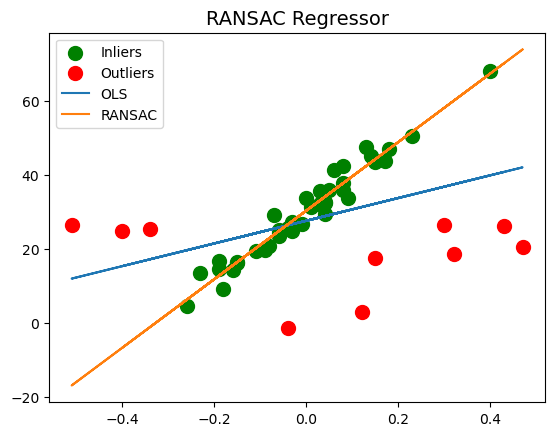

In [6]:
import numpy as np
from sklearn.linear_model import RANSACRegressor
from sklearn import linear_model
import matplotlib.pyplot as plt

# sample data
X = np.array([ 0.15, -0.34, 0.32, 0.43, -0.4, -0.04, -0.51, 0.3, 0.47, 0.12, 0.08, 0.04, -0.08, 
              -0.23, 0.08, -0.03, 0.03, 0.04, 0.01, 0.06, 0.03, 0., -0.04, -0.18, -0.19, -0.06, 
              -0.26, -0.16, 0.13, 0.09, 0.03, -0.03, 0.04, 0.14, -0.01, 0.4, -0.06, 0.15, 0.08, 
              0.05, -0.15, -0.09, -0.15, -0.11, -0.07, -0.19, -0.06, 0.17, 0.23, 0.18]).reshape(-1, 1)
y = np.array([17.44, 25.46, 18.61, 26.07, 24.96, -1.22, 26.45, 26.5, 20.57, 3.08, 35.9 , 32.47, 
              20.84, 13.37, 42.44, 27.23, 35.65, 29.51, 31.28, 41.34, 32.19, 33.67, 25.64, 9.3, 
              14.63, 25.1, 4.69, 14.42, 47.53, 33.82, 32.2 , 24.81, 32.64, 45.11, 26.76, 68.01, 
              23.39, 43.49, 37.88, 36.01, 16.32, 19.77, 16.34, 19.57, 29.28, 16.62, 24.39, 43.77, 
              50.46, 47.09])

# fit and predict: RANSAC
ransac = RANSACRegressor(random_state=1).fit(X, y)      
y_pred_ransac = ransac.predict(X)

# retrieve the fitted parameters
coefs = ransac.estimator_.coef_              # RANSAC fits many regression models. The ".estimator_" attribute
intercept = ransac.estimator_.intercept_     # has the final model fitted. 

# seperate into inliers vs. outliers
X_inlier = X[ransac.inlier_mask_ ]
y_inlier = y[ransac.inlier_mask_ ]
X_outlier = X[~ransac.inlier_mask_ ]
y_outlier = y[~ransac.inlier_mask_ ]

print("RANSAC -----------------------------------\n")
print("Coefficients         :", coefs)
print("Intercept            :", intercept)
print("# of inliers         :", sum(ransac.inlier_mask_))
print("Fraction of inliers  :", sum(ransac.inlier_mask_) / len(y))
print("\n------------------------------------------")

# fit and predict: Ordinary Least Squares
ols = linear_model.LinearRegression().fit(X, y)
y_pred_ols = ols.predict(X)

# plot
plt.title('RANSAC Regressor', fontsize=14)
plt.scatter(X_inlier, y_inlier, s=100, c='green', label='Inliers')
plt.scatter(X_outlier, y_outlier, s=100, c='red', label='Outliers')
plt.plot(X, y_pred_ols, label='OLS')
plt.plot(X, y_pred_ransac, label='RANSAC')
plt.legend();

<div class="highlights red-theme" id="boxcox-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme">RANSAC employs random sampling. With a substantial dataset (>50 points), your regression results may vary due to this randomness. The benefit is flexibility for fine-tuning (try repeatedly running the same code without fixing a random seed), but the drawback is inconsistency when sharing code or results. To ensure consistency, set a random seed: <code>model = RANSACRegressor(random_state=3)</code>.</code>.
    </div>
</div>

<div id="Huber regressor"></div>

### 2.2. Huber regressor

The Huber regressor doesn't eliminate outliers but mitigates their effect, making it a preferred choice when you have reason to believe that so-called outliers may have relevance in the regression analysis. In contrast to other robust regression techniques like RANSAC or Theil-Sen, which involve substantial structural modifications in their algorithms compared to default linear regression, such as subsampling and fitting regressions on these subsets, the Huber regressor differes only in its choice of loss function while retaining the fundamental structure of default linear regression.

<div><hr></div>

<div id="Huber loss function"></div>

**Huber loss function**

The original Huber loss is a piece-wise function shown in <a href="#eq-?">eq (?)</a>. Note that the term, $y - \hat{y}$, are often referred to as residuals (prediction error).

<div id="eq-?" style="font-size: 1rem;">
$$ L_{\delta} (y - \hat{y})=   \left\{
    \begin{array}{ll}
          \frac{1}{2}(y - \hat{y})^{2} & \text{for } |y - \hat{y}| \leq \delta \text{ (inlier)},  \\
          \delta \cdot (|y - \hat{y}| - \frac{1}{2}\delta) &  \text{otherwise (outlier)}.  \\
    \end{array} 
    \right.  
    \tag{4}$$
</div>

<div class="eq-terms">
    <div class="row eq-terms-where">where</div>
    <div class="row">
        <div class="col-3">$y$</div>
        <div class="col-9">: observation, original data point</div>
    </div>
    <div class="row">
        <div class="col-3">$\hat{y}$</div>
        <div class="col-9">: prediction</div>
    </div>
    <div class="row">
        <div class="col-3">$\delta$</div>
        <div class="col-9">: parameter that controls the number of outliers</div>
    </div>    
    <div class="row">
        <div class="col-3">$L$</div>
        <div class="col-9">: loss function</div>
    </div>    
</div>

<div id="Motivation"></div>

**Motivation**

The two most commonly used loss functions are squared loss, $L(y - \hat{y}) = (y - \hat{y})^2$ and absolute loss, $L(y - \hat{y}) = |y - \hat{y}|$. While the squared loss is more accurate, it has the disadvantage that it has the tendency to be dominated by outliers. This susceptibility arises because squared residuals magnify the effect of outliers, as the residuals are squared, leading to an exponential increase in loss as residuals grow. In contrast, absolute loss grows linearly with residuals, rendering it more robust to outliers.

The Huber regressor offers a compelling compromise, leveraging the strengths of squared and absolute loss functions while mitigating their weaknesses. It employs squared loss for small-residual data points (inliers) and absolute loss for large-residual data points (outliers). The distinction between inliers and outliers is governed by the $\delta$ parameter, set to 1.35 by default in scikit-learn.

<div id="Parameter tuning"></div>

**Parameter tuning ($\delta$)**

The $\delta$ parameter controls the residual threshold for determining whether squared loss or Huber loss is applied. As shown in <a href="fig-">Figure ?</a>, smaller $\delta$ values lead to a more robust approach by applying Huber loss to a greater number of data points, emphasizing absolute loss. Conversely, larger $\delta$ values result in squared loss being more prevalent, making the method more susceptible to outliers. Notably, for very large $\delta$ values, Huber loss converges to squared loss, as described in <a href="#eq-?">eq (?)</a>:


<div id="eq-?" style="font-size: 1rem;">
$$ \lim_{\delta\to \infty}: \text{Huber Loss} \approx \text{Squared Loss} \tag{4}$$
</div>

Note that in the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html" target=_blank>scikit-learn implementation</a>, the residuals are divided by the scale parameter sigma <code>|(y - Xw - c) / sigma|</code> to ensure that one does not need to rescale epsilon to achieve the same robustness. The default value of $\delta$ in scikit-learn is 1.35.

<div class="row" style="margin-top: 15px;">
<div class="col"><img src="jupyter_images/huber loss effect of delta.png"></div>
<div class="col-12"><p class="image-description"><strong>Figure ?:</strong> $\delta$ controls the residual thresholds used to determine whether to compute squared loss or Huber loss. Small value of $\delta$ (left plot) allows Huber loss to be applied for wider residual ranges of data, making it more robust to outliers. </p></div>
</div>

<div class="solution_panel closed">
    <div class="solution_title">
        <p class="solution_title_string">Source Code For Figure (?)</p>
        <ul class="nav navbar-right panel_toolbox">
            <li><a class="collapse-link"><i class="fa fa-chevron-down"></i></a></li>
        </ul>
    <div class="clearfix"></div>
    </div>
    <div class="solution_content">
        <pre>
            <code class="language-python">
import numpy as np
import matplotlib.pyplot as plt


error_range = np.linspace(-3.3, 3.3, 100)
theta_values = [1.35, 2.35]

huber_color = 'blue'
squared_color = 'green'
fig, axes = plt.subplots(1, len(theta_values), figsize=(9, 4.5))

for i, theta in enumerate(theta_values):
    huber_loss = np.where(np.abs(error_range) <= theta, 0.5 * error_range ** 2, theta * (np.abs(error_range) - 0.5 * theta))
    squared_error_loss = 0.5 * error_range ** 2

    ax = axes[i]

    # Set the range for which the line styles and alphas will change
    x_range = (-theta, theta)

    # Plot Huber Loss line
    huber_loss_segment = np.where((error_range >= x_range[0]) & (error_range <= x_range[1]), huber_loss, np.nan)
    ax.plot(error_range, huber_loss_segment, linewidth=2, zorder=3, alpha=0.3, linestyle='dashed', color=huber_color)
    huber_loss_segment = np.where((error_range < x_range[0]) | (error_range > x_range[1]), huber_loss, np.nan)
    ax.plot(error_range, huber_loss_segment, label='Huber Loss', linewidth=2, zorder=3, alpha=1, linestyle='-', color=huber_color)

    # Plot Squared Loss line
    squared_loss_segment = np.where((error_range >= x_range[0]) & (error_range <= x_range[1]), squared_error_loss, np.nan)
    ax.plot(error_range, squared_loss_segment, label='Squared Loss', linewidth=2, zorder=3, alpha=1, linestyle='-', color=squared_color)
    squared_loss_segment = np.where((error_range < x_range[0]) | (error_range > x_range[1]), squared_error_loss, np.nan)
    ax.plot(error_range, squared_loss_segment, linewidth=2, zorder=3, alpha=0.3, linestyle='dashed', color=squared_color)
    
    # Fill the area between the axvlines
    fill_alpha = 0.03
    ax.axvspan(-5, -theta, alpha=fill_alpha, color=huber_color, zorder=-8, label='Outliers')
    ax.axvspan(theta, 5, alpha=fill_alpha, color=huber_color, zorder=-9)
    ax.axvspan(-theta, theta, alpha=fill_alpha, color=squared_color, zorder=-9, label='Inliers')
    
    ax.set_xlabel('Residuals ($y - \\hat{y}$)', fontsize=13)
    ax.set_ylabel('Loss', fontsize=13)
    ax.grid(True, alpha=0.3)
    
    lg = ax.legend(loc='upper center', ncol=2)
    for i, lh in enumerate(lg.legendHandles):
        if i > 1:
            lh.set_alpha(0.4)
    
    ax.axvline(x=theta, color='r', linestyle="dotted", alpha=0.7)
    ax.axvline(x=-theta, color='r', linestyle="dotted", alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-3.3, 3.3)

    ax.text(0, 3.5, '$\delta = %.2f$' % theta,
            fontsize=13, ha='center', va='top', color='r', alpha=0.7, rotation=0)
    ax.text(0.05, 0.1, 'aegis4048.github.io', fontsize=10, ha='left', va='center',
        transform=ax.transAxes, color='grey', alpha=0.5)
    
    
axes[0].text(3, 0.1, 'more robust', ha='right', fontsize=13, bbox=dict( facecolor='white'))
axes[1].text(3, 0.1, 'less robust', ha='right', fontsize=13, bbox=dict( facecolor='white'))

def setbold(txt):
    return ' '.join([r"$\bf{" + item + "}$" for item in txt.split(' ')])   

bold_txt = setbold('Huber Loss, ')
plain_txt = r'effect of $\delta$-parameter on inlier vs. outlier detection'
fig.suptitle(bold_txt + plain_txt, verticalalignment='top', x=0, horizontalalignment='left', fontsize=11)
yloc = 0.9
ax.annotate('', xy=(0.01, yloc + 0.01), xycoords='figure fraction', xytext=(1.02, yloc + 0.01),
            arrowprops=dict(arrowstyle="-", color='k', lw=0.7))

fig.tight_layout()
            </code>
        </pre>
    </div>
</div>

<div id="Huber code snippets" style="margin-top: -15px"></div>

**Huber code snippets**

For quick copy-paste, replace <code>X</code> and <code>y</code> with your own data. Make sure to reshape your <code>X</code> so that it is a 2D <code>numpy.ndarray</code> object with shape like <code>(13, 1)</code>.

Huber -----------------------------------

Coefficients         : [50.32948547]
Intercept            : 29.03041669256188
# of inliers         : 31
Fraction of inliers  : 0.62

------------------------------------------


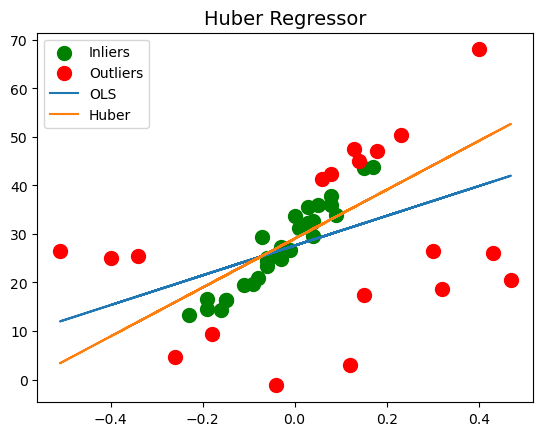

In [4]:
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
import matplotlib.pyplot as plt

# sample data
X = np.array([ 0.15, -0.34, 0.32, 0.43, -0.4, -0.04, -0.51, 0.3, 0.47, 0.12, 0.08, 0.04, -0.08, 
              -0.23, 0.08, -0.03, 0.03, 0.04, 0.01, 0.06, 0.03, 0., -0.04, -0.18, -0.19, -0.06, 
              -0.26, -0.16, 0.13, 0.09, 0.03, -0.03, 0.04, 0.14, -0.01, 0.4, -0.06, 0.15, 0.08, 
              0.05, -0.15, -0.09, -0.15, -0.11, -0.07, -0.19, -0.06, 0.17, 0.23, 0.18]).reshape(-1, 1)
y = np.array([17.44, 25.46, 18.61, 26.07, 24.96, -1.22, 26.45, 26.5, 20.57, 3.08, 35.9 , 32.47, 
              20.84, 13.37, 42.44, 27.23, 35.65, 29.51, 31.28, 41.34, 32.19, 33.67, 25.64, 9.3, 
              14.63, 25.1, 4.69, 14.42, 47.53, 33.82, 32.2 , 24.81, 32.64, 45.11, 26.76, 68.01, 
              23.39, 43.49, 37.88, 36.01, 16.32, 19.77, 16.34, 19.57, 29.28, 16.62, 24.39, 43.77, 
              50.46, 47.09])

# fit and predict: Huber 
huber = HuberRegressor(epsilon=1.35).fit(X, y)   # 1.35 is the default. You can try different epsilon values.
y_pred_huber = huber.predict(X)

# retrieve the fitted parameters
coefs = huber.coef_
intercept = huber.intercept_

# seperate into inliers vs. outliers
X_inlier = X[~huber.outliers_]
y_inlier = y[~huber.outliers_]
X_outlier = X[huber.outliers_]
y_outlier = y[huber.outliers_]

print("Huber -----------------------------------\n")
print("Coefficients         :", coefs)
print("Intercept            :", intercept)
print("# of inliers         :", sum(~huber.outliers_))
print("Fraction of inliers  :", sum(~huber.outliers_) / len(y))
print("\n------------------------------------------")

# fit and predict: Ordinary Least Squares
ols = linear_model.LinearRegression().fit(X, y)
y_pred_ols = ols.predict(X)

# plot
plt.title('Huber Regressor', fontsize=14)
plt.scatter(X_inlier, y_inlier, s=100, c='green', label='Inliers')
plt.scatter(X_outlier, y_outlier, s=100, c='red', label='Outliers')
plt.plot(X, y_pred_ols, label='OLS')
plt.plot(X, y_pred_huber, label='Huber')
plt.legend();

<div class="highlights red-theme" id="boxcox-warning">
    <div class="highlights-title red-theme">WARNING!</div>
    <div class="highlights-content red-theme">Despite the application of the robust Huber regressor, the regression fit in the plot above (Figure ?) is still notably influenced by the presence of outliers, albeit to a lesser extent. This influence persists because, instead of completely excluding outliers during the fitting process, Huber aims to attenuate their impact by employing absolute loss rather than squared loss. Therefore, unless there is a compelling reason to retain and account for the so-called "outliers" within your data, using the Huber regressor is not typically recommended.
    </div>
</div>

<div id="Theil-Sen regressor"></div>

### 2.3. Theil-Sen regressor

The Huber regressor doesn't eliminate outliers but mitigates their effect, making it a preferred choice when you have reason to believe that so-called outliers may have relevance in the regression analysis. In contrast to other robust regression techniques like RANSAC or Theil-Sen, which involve substantial structural modifications in their algorithms compared to default linear regression, such as subsampling and fitting regressions on these subsets, the Huber regressor differes only in its choice of loss function while retaining the fundamental structure of default linear regression.


In [61]:
xmin

0.0

https://www.section.io/engineering-education/understanding-loss-functions-in-machine-learning/

### Use Huber regressor only if you know that outliers are not really outliers.

Huber -----------------------------------

Coefficients         : [50.32948547]
Intercept            : 29.03041669256188
# of inliers         : 31
Fraction of inliers  : 0.62

------------------------------------------


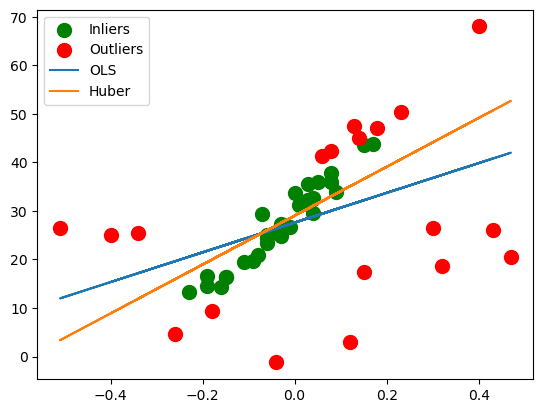

In [1]:
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
import matplotlib.pyplot as plt

# sample data
X = np.array([ 0.15, -0.34, 0.32, 0.43, -0.4, -0.04, -0.51, 0.3, 0.47, 0.12, 0.08, 0.04, -0.08, 
              -0.23, 0.08, -0.03, 0.03, 0.04, 0.01, 0.06, 0.03, 0., -0.04, -0.18, -0.19, -0.06, 
              -0.26, -0.16, 0.13, 0.09, 0.03, -0.03, 0.04, 0.14, -0.01, 0.4, -0.06, 0.15, 0.08, 
              0.05, -0.15, -0.09, -0.15, -0.11, -0.07, -0.19, -0.06, 0.17, 0.23, 0.18]).reshape(-1, 1)
y = np.array([17.44, 25.46, 18.61, 26.07, 24.96, -1.22, 26.45, 26.5, 20.57, 3.08, 35.9 , 32.47, 
              20.84, 13.37, 42.44, 27.23, 35.65, 29.51, 31.28, 41.34, 32.19, 33.67, 25.64, 9.3, 
              14.63, 25.1, 4.69, 14.42, 47.53, 33.82, 32.2 , 24.81, 32.64, 45.11, 26.76, 68.01, 
              23.39, 43.49, 37.88, 36.01, 16.32, 19.77, 16.34, 19.57, 29.28, 16.62, 24.39, 43.77, 
              50.46, 47.09])

# fit and predict: Huber 
huber = HuberRegressor(epsilon=1.35).fit(X, y)   # 1.35 is the default. You can try different epsilon values.
y_pred_huber = huber.predict(X)

# retrieve the fitted parameters
coefs = huber.coef_
intercept = huber.intercept_

# seperate into inliers vs. outliers
X_inlier = X[~huber.outliers_]
y_inlier = y[~huber.outliers_]
X_outlier = X[huber.outliers_]
y_outlier = y[huber.outliers_]

print("Huber -----------------------------------\n")
print("Coefficients         :", coefs)
print("Intercept            :", intercept)
print("# of inliers         :", sum(~huber.outliers_))
print("Fraction of inliers  :", sum(~huber.outliers_) / len(y))
print("\n------------------------------------------")

# fit and predict: Ordinary Least Squares
ols = linear_model.LinearRegression().fit(X, y)
y_pred_ols = ols.predict(X)

# plot
plt.scatter(X_inlier, y_inlier, s=100, c='green', label='Inliers')
plt.scatter(X_outlier, y_outlier, s=100, c='red', label='Outliers')
plt.plot(X, y_pred_ols, label='OLS')
plt.plot(X, y_pred_huber, label='Huber')
plt.legend();

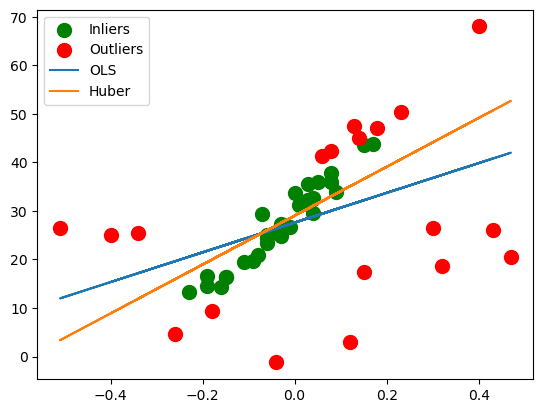

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import HuberRegressor

######################################## Data preparation #########################################

X = np.array([ 0.15, -0.34, 0.32, 0.43, -0.4, -0.04, -0.51, 0.3, 0.47, 0.12, 0.08, 0.04, -0.08, 
              -0.23, 0.08, -0.03, 0.03, 0.04, 0.01, 0.06, 0.03, 0., -0.04, -0.18, -0.19, -0.06, 
              -0.26, -0.16, 0.13, 0.09, 0.03, -0.03, 0.04, 0.14, -0.01, 0.4, -0.06, 0.15, 0.08, 
              0.05, -0.15, -0.09, -0.15, -0.11, -0.07, -0.19, -0.06, 0.17, 0.23, 0.18]).reshape(-1, 1)
y = np.array([17.44, 25.46, 18.61, 26.07, 24.96, -1.22, 26.45, 26.5, 20.57, 3.08, 35.9 , 32.47, 
              20.84, 13.37, 42.44, 27.23, 35.65, 29.51, 31.28, 41.34, 32.19, 33.67, 25.64, 9.3, 
              14.63, 25.1, 4.69, 14.42, 47.53, 33.82, 32.2 , 24.81, 32.64, 45.11, 26.76, 68.01, 
              23.39, 43.49, 37.88, 36.01, 16.32, 19.77, 16.34, 19.57, 29.28, 16.62, 24.39, 43.77, 
              50.46, 47.09])

################################################ Train #############################################

huber = HuberRegressor(epsilon=1.35).fit(X, y)
y_pred_huber = huber.predict(X)


# retrieve the fitted parameters
coefs = huber.coef_          
intercept = huber.intercept_     

X_inlier = X[~huber.outliers_]
y_inlier = y[~huber.outliers_]
X_outlier = X[huber.outliers_]
y_outlier = y[huber.outliers_]





print("RANSAC -----------------------------------\n")
print("Coefficients         :", coefs)
print("Intercept            :", intercept)
print("# of inliers         :", sum(inlier_mask))
print("Fraction of inliers  :", sum(inlier_mask) / len(y))
print("\n------------------------------------------")


# fit and predict: Ordinary Least Squares
ols = linear_model.LinearRegression().fit(X, y)
y_pred_ols = ols.predict(X)

############################################## Evaluate ############################################

plt.scatter(X_inlier, y_inlier, s=100, c='green', label='Inliers')
plt.scatter(X_outlier, y_outlier, s=100, c='red', label='Outliers')
plt.plot(X, y_pred_ols, label='OLS')
plt.plot(X, y_pred_huber, label='Huber')
plt.legend();

Theilsen - 
* Becomes OLS in high dimension
* Uses median
* It can take upto arbitrary corruption data of upto 29.3%
* Uses bootstrap method - fits data on all possible combinations of subsamples, and takes the median
* `max_subpopulation` - restricts the magnitude of all possible combinations of p subsample points to a randomly chosen subset and therefore limits the runtime. Applicable to larger problems by losing some of its mathematical properties. 
* n choose k formula - combinations

RANSAC -
* Determined only from the filtered "inliers"
* https://hands-on.cloud/using-the-random-sample-consensus-ransac-algorithm-in-python/
* Card section for median of least squares

Huber
* Does not completely try to eliminate outliers, try to lessen the impact.
* assigns less weight on outliers


https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/

## 4. Caveats

* Outliers are requirement of a model - are they truly an outlier?

## 5. Advanced: Robust Non-linear regression - sinusoidal

https://ostwalprasad.github.io/machine-learning/Robust-Regression-models-using-scikit-learn.html

## 6. Speed comparison

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

######################################## Data preparation #########################################

file = 'https://aegis4048.github.io/downloads/notebooks/sample_data/unconv_MV_v5.csv'
df = pd.read_csv(file)

X = df['Por'].values.reshape(-1,1)
y = df['Prod'].values

################################################ Train #############################################

ols = linear_model.LinearRegression()
model = ols.fit(X, y)
response = model.predict(X)

############################################## Evaluate ############################################

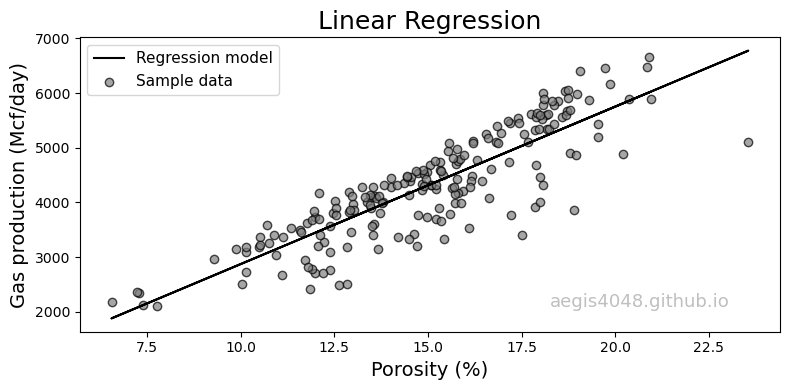

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X, response, color='k', label='Regression model')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Gas production (Mcf/day)', fontsize=14)
ax.set_xlabel('Porosity (%)', fontsize=14)
ax.text(0.8, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('Linear Regression', fontsize=18)

fig.tight_layout()

In [8]:
from sklearn.linear_model import (LinearRegression, HuberRegressor,
                              	RANSACRegressor, TheilSenRegressor)

In [9]:
x_min = X.flatten().min()
x_max = X.flatten().max()

x_pred = np.linspace(x_min, x_max, 200)
x_pred = x_pred.reshape(-1, 1)

In [10]:
huber = HuberRegressor().fit(X, y)
y_pred_huber = huber.predict(x_pred)

In [11]:
TS = TheilSenRegressor().fit(X, y)
y_pred_TS = TS.predict(x_pred)

In [15]:
TS.coef_

array([300.70846827])

In [20]:
TS.breakdown_

0.2914287527193852

In [21]:
TS.n_iter_

62

In [22]:
TS.n_subpopulation_

10000

In [24]:
TS.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'max_iter': 300,
 'max_subpopulation': 10000,
 'n_jobs': None,
 'n_subsamples': None,
 'random_state': None,
 'tol': 0.001,
 'verbose': False}

In [202]:
from sklearn.datasets import make_regression
from random import seed
from random import randint
from random import random

def get_dataset(random_state=10, n_samples=50):
    
    # random_state = 10 is good
    
    X, y = make_regression(
        n_samples=50, 
        n_features=1, 
        effective_rank=1, 
        noise=3, 
        bias=30, 
        random_state=random_state
    )
    seed(1)
    for i in range(10):
        factor = randint(2, 4)
        if random() > 0.5:
            X[i] += factor * X.std()
        else:
            X[i] -= factor * X.std()
    return X, y
 

for i in range(0, 30):
    
    X, y = get_dataset(random_state=i)
    
    #fig, ax = plt.subplots(figsize=(4, 3))
    
    #ax.scatter(X, y)
    #ax.set_title(i)

6


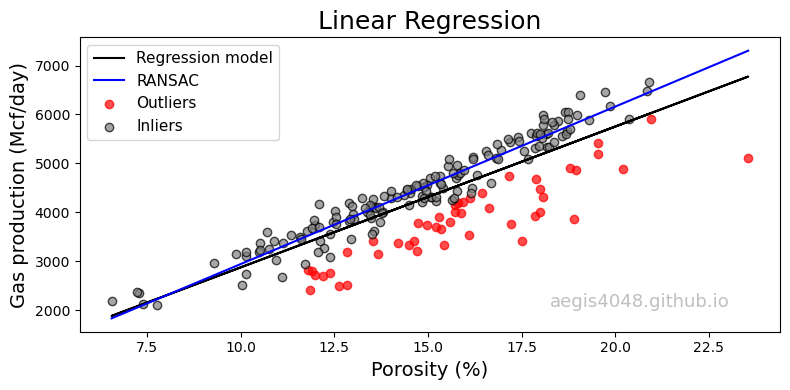

In [62]:
ransac = RANSACRegressor(min_samples=2, max_trials=1000, random_state=8).fit(X, y)
y_pred_ransac = ransac.predict(x_pred)

print(ransac.n_trials_)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X, response, color='k', label='Regression model')
#ax.plot(x_pred, y_pred_huber, color='r', label='Huber')
ax.plot(x_pred, y_pred_ransac, color='blue', label='RANSAC')
#ax.plot(x_pred, y_pred_ransac, color='green', label='Ransac')
#ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')

ax.scatter(X[~ransac.inlier_mask_], y[~ransac.inlier_mask_], edgecolor='r', facecolor='red', alpha=0.7, label='Outliers')
ax.scatter(X[ransac.inlier_mask_], y[ransac.inlier_mask_], edgecolor='k', facecolor='grey', alpha=0.7, label='Inliers')

ax.set_ylabel('Gas production (Mcf/day)', fontsize=14)
ax.set_xlabel('Porosity (%)', fontsize=14)
ax.text(0.8, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('Linear Regression', fontsize=18)

fig.tight_layout()

In [40]:
X.shape[1]

1

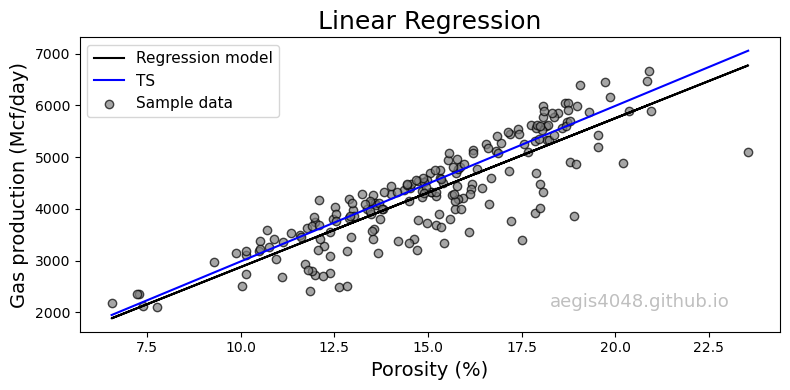

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X, response, color='k', label='Regression model')
#ax.plot(x_pred, y_pred_huber, color='r', label='Huber')
ax.plot(x_pred, y_pred_TS, color='blue', label='TS')
#ax.plot(x_pred, y_pred_ransac, color='green', label='Ransac')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Gas production (Mcf/day)', fontsize=14)
ax.set_xlabel('Porosity (%)', fontsize=14)
ax.text(0.8, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
         transform=ax.transAxes, color='grey', alpha=0.5)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('Linear Regression', fontsize=18)

fig.tight_layout()

Theilsen - 
* Becomes OLS in high dimension
* Uses median
* It can take upto arbitrary corruption data of upto 29.3%
* Uses bootstrap method - fits data on all possible combinations of subsamples, and takes the median
* `max_subpopulation` - restricts the magnitude of all possible combinations of p subsample points to a randomly chosen subset and therefore limits the runtime. Applicable to larger problems by losing some of its mathematical properties. 
* n choose k formula - combinations

RANSAC -
* Determined only from the filtered "inliers"
* https://hands-on.cloud/using-the-random-sample-consensus-ransac-algorithm-in-python/
* Card section for median of least squares


In [2]:
x

array([201., 244.,  47., 287., 203.,  58., 210., 202., 198., 158., 165.,
       201., 157., 131., 166., 160., 186., 125., 218., 146.])

In [3]:
y

array([592., 401., 583., 402., 495., 173., 479., 504., 510., 416., 393.,
       442., 317., 311., 400., 337., 423., 334., 533., 344.])

In [4]:
dy

array([61., 25., 38., 15., 21., 15., 27., 14., 30., 16., 14., 25., 52.,
       16., 34., 31., 42., 26., 16., 22.])

In [11]:
X = np.array([ 0.15, -0.34, 0.32, 0.43, -0.4, -0.04, -0.51, 0.3, 0.47, 0.12, 0.08, 0.04, -0.08, 
              -0.23, 0.08, -0.03, 0.03, 0.04, 0.01, 0.06, 0.03, 0., -0.04, -0.18, -0.19, -0.06, 
              -0.26, -0.16, 0.13, 0.09, 0.03, -0.03, 0.04, 0.14, -0.01, 0.4, -0.06, 0.15, 0.08, 
              0.05, -0.15, -0.09, -0.15, -0.11, -0.07, -0.19, -0.06, 0.17, 0.23, 0.18]).reshape(-1, 1)
y = np.array([17.44, 25.46, 18.61, 26.07, 24.96, -1.22, 26.45, 26.5, 20.57, 3.08, 35.9 , 32.47, 
              20.84, 13.37, 42.44, 27.23, 35.65, 29.51, 31.28, 41.34, 32.19, 33.67, 25.64, 9.3, 
              14.63, 25.1, 4.69, 14.42, 47.53, 33.82, 32.2 , 24.81, 32.64, 45.11, 26.76, 68.01, 
              23.39, 43.49, 37.88, 36.01, 16.32, 19.77, 16.34, 19.57, 29.28, 16.62, 24.39, 43.77, 
              50.46, 47.09])

In [12]:
import numbers

def _num_samples(x):
    if hasattr(x, "fit") and callable(x.fit):
        # Don't get num_samples from an ensembles length!
        raise TypeError(message)

    if not hasattr(x, "__len__") and not hasattr(x, "shape"):
        if hasattr(x, "__array__"):
            x = np.asarray(x)
        else:
            raise TypeError(message)

    if hasattr(x, "shape") and x.shape is not None:
        if len(x.shape) == 0:
            raise TypeError(
                "Singleton array %r cannot be considered a valid collection." % x
            )
        # Check that shape is returning an integer or default to len
        # Dask dataframes may not return numeric shape[0] value
        if isinstance(x.shape[0], numbers.Integral):
            return x.shape[0]

    try:
        return len(x)
    except TypeError as type_error:
        raise TypeError(message) from type_error

        
def _check_sample_weight(
    sample_weight, X, dtype=None, copy=False, only_non_negative=False
):
    n_samples = _num_samples(X)

    if dtype is not None and dtype not in [np.float32, np.float64]:
        dtype = np.float64

    if sample_weight is None:
        sample_weight = np.ones(n_samples, dtype=dtype)
    elif isinstance(sample_weight, numbers.Number):
        sample_weight = np.full(n_samples, sample_weight, dtype=dtype)
    else:
        if dtype is None:
            dtype = [np.float64, np.float32]
        sample_weight = check_array(
            sample_weight,
            accept_sparse=False,
            ensure_2d=False,
            dtype=dtype,
            order="C",
            copy=copy,
            input_name="sample_weight",
        )
        if sample_weight.ndim != 1:
            raise ValueError("Sample weights must be 1D array or scalar")

        if sample_weight.shape != (n_samples,):
            raise ValueError(
                "sample_weight.shape == {}, expected {}!".format(
                    sample_weight.shape, (n_samples,)
                )
            )

    if only_non_negative:
        check_non_negative(sample_weight, "`sample_weight`")

    return sample_weight

def safe_mask(X, mask):
    mask = np.asarray(mask)
    if np.issubdtype(mask.dtype, np.signedinteger):
        return mask

    if hasattr(X, "toarray"):
        ind = np.arange(mask.shape[0])
        mask = ind[mask]
    return mask

def axis0_safe_slice(X, mask, len_mask):

    if len_mask != 0:
        return X[safe_mask(X, mask), :]
    return np.zeros(shape=(0, X.shape[1]))

In [44]:
from sklearn.utils.extmath import safe_sparse_dot
from scipy import optimize

def _huber_loss_and_gradient(w, X, y, epsilon, alpha, sample_weight=None):
    
    print(w)
    
    _, n_features = X.shape
    fit_intercept = n_features + 2 == w.shape[0]
    if fit_intercept:
        intercept = w[-2]
    sigma = w[-1]
    
    # w = [feature, intercept, sigma]
    w = w[:n_features]
    n_samples = np.sum(sample_weight)
    

    # Calculate the values where |y - X'w -c / sigma| > epsilon
    # The values above this threshold are outliers.
    linear_loss = y - safe_sparse_dot(X, w)
    if fit_intercept:
        linear_loss -= intercept
    abs_linear_loss = np.abs(linear_loss)
    outliers_mask = abs_linear_loss > epsilon * sigma

    # Calculate the linear loss due to the outliers.
    # This is equal to (2 * M * |y - X'w -c / sigma| - M**2) * sigma
    outliers = abs_linear_loss[outliers_mask]
    num_outliers = np.count_nonzero(outliers_mask)
    n_non_outliers = X.shape[0] - num_outliers

    # n_sq_outliers includes the weight give to the outliers while
    # num_outliers is just the number of outliers.
    outliers_sw = sample_weight[outliers_mask]
    n_sw_outliers = np.sum(outliers_sw)
    outlier_loss = (
        2.0 * epsilon * np.sum(outliers_sw * outliers)
        - sigma * n_sw_outliers * epsilon**2
    )

    # Calculate the quadratic loss due to the non-outliers.-
    # This is equal to |(y - X'w - c)**2 / sigma**2| * sigma
    non_outliers = linear_loss[~outliers_mask]
    weighted_non_outliers = sample_weight[~outliers_mask] * non_outliers
    weighted_loss = np.dot(weighted_non_outliers.T, non_outliers)
    squared_loss = weighted_loss / sigma

    if fit_intercept:
        grad = np.zeros(n_features + 2)
    else:
        grad = np.zeros(n_features + 1)

    # Gradient due to the squared loss.
    X_non_outliers = -axis0_safe_slice(X, ~outliers_mask, n_non_outliers)
    grad[:n_features] = (
        2.0 / sigma * safe_sparse_dot(weighted_non_outliers, X_non_outliers)
    )

    # Gradient due to the linear loss.
    signed_outliers = np.ones_like(outliers)
    signed_outliers_mask = linear_loss[outliers_mask] < 0
    signed_outliers[signed_outliers_mask] = -1.0
    X_outliers = axis0_safe_slice(X, outliers_mask, num_outliers)
    sw_outliers = sample_weight[outliers_mask] * signed_outliers
    grad[:n_features] -= 2.0 * epsilon * (safe_sparse_dot(sw_outliers, X_outliers))

    # Gradient due to the penalty.
    grad[:n_features] += alpha * 2.0 * w

    # Gradient due to sigma.
    grad[-1] = n_samples
    grad[-1] -= n_sw_outliers * epsilon**2
    grad[-1] -= squared_loss / sigma

    # Gradient due to the intercept.
    if fit_intercept:
        grad[-2] = -2.0 * np.sum(weighted_non_outliers) / sigma
        grad[-2] -= 2.0 * epsilon * np.sum(sw_outliers)

    loss = n_samples * sigma + squared_loss + outlier_loss
    loss += alpha * np.dot(w, w)

    #print("Outlier Loss: ", outlier_loss)
    #print("np.sum(outliers_sw * outliers): ", np.sum(outliers_sw * outliers))
    #print("outliers_sw: ", outliers_sw)
    #print("outliers: ", outliers)
    #print("n_sw_outliers: ", n_sw_outliers)
    
    #print("sample_weight[~outliers_mask:", sample_weight[~outliers_mask])
    #print("weighted_non_outliers.T:", weighted_non_outliers.T)
    #print("non_outliers:" , non_outliers)
    #print("sample_weight[~outliers_mask]: ", sample_weight[~outliers_mask])
    print(loss)
    print('------------------------------')
    
    return loss, grad

In [45]:
sample_weight = None
sample_weight = _check_sample_weight(sample_weight, X)

parameters = np.zeros(X.shape[1] + 2)

bounds = np.tile([-np.inf, np.inf], (parameters.shape[0], 1))
bounds[-1][0] = np.finfo(np.float64).eps * 10

opt_res = optimize.minimize(
    _huber_loss_and_gradient,
    parameters,
    method="L-BFGS-B",
    jac=True,
    args=(X, y, 1.35, 0.0001, sample_weight),
    options={"maxiter": 100, "gtol": 1e-05, "iprint": -1},
    bounds=bounds,
)

print(opt_res)

[0.00000000e+00 0.00000000e+00 2.22044605e-15]
3767.2830000000004
------------------------------
[0.00972974 0.95311702 0.3024455 ]
3631.3080907283793
------------------------------
[0.04864868 4.76558509 1.51222752]
3099.5517653032175
------------------------------
[ 0.20432446 20.01545737  6.35135559]
1410.7860827918864
------------------------------
[ 3.24123677 37.62736135  7.89920988]
1552.9110160587811
------------------------------
[ 1.49996885 27.52926162  7.01171998]
1176.5442862388968
------------------------------
[ 2.42823828 27.44083243  7.46807196]
1168.296730982608
------------------------------
[14.90649749 27.13792982  9.77185586]
1110.160424191842
------------------------------
[24.30856005 27.7300758   8.89140562]
1079.044166289982
------------------------------
[31.56195168 28.42193093  7.62340275]
1066.6558170246344
------------------------------
[36.95026939 28.76642621  7.05650623]
1063.6099795434234
------------------------------
[40.47019657 28.86441332  6.6242

https://www.activeloop.ai/resources/glossary/huber-loss/#:~:text=Huber%20loss%20is%20a%20combination,be%20sensitive%20to%20extreme%20values.

https://www.astroml.org/book_figures/chapter8/fig_huber_loss.html

In [6]:
huber.coef_

array([50.32948547])

In [7]:
huber.intercept_

29.03041669256188

In [8]:
huber.scale_

5.330576534578339

In [9]:
huber_loss_and_gradient(np.zeros(X.shape[1] + 2), X, y, epsilon=1.35, alpha=0.0001, )

NameError: name 'huber_loss_and_gradient' is not defined

https://online.stat.psu.edu/stat501/lesson/t/t.1/t.1.1-robust-regression-methods

"These methods attempt to dampen the influence of outlying cases in order to provide a better fit to the majority of the data. Outliers have a tendency to pull the least squares fit too far in their direction by receiving much more "weight" than they deserve. Robust regression down-weights the influence of outliers, which makes their residuals larger and easier to identify. Also the outliers maybe difficult to identify in presence of multiple predictor variables."

Ordinary least squares are sometimes known as L2-norm regression since it is minimizing the L2-norm of the residuals (i.e., the squares of the residuals). Thus, observations with high residuals (and high squared residuals) will pull the least squares to fit more in that direction.

An alternative is to use what is sometimes known as least absolute deviation (or L1-norm regression), which minimizes the L1-norm of the residuals (i.e., the absolute value of the residuals)

" iteratively reweighted least squares (IRLS) "


https://developer.nvidia.com/blog/dealing-with-outliers-using-three-robust-linear-regression-models/
(good examples with sample data generation codes)


"Connected to the previous point is the fact that optimizing the squared loss results in an unbiased estimator around the mean, while the absolute difference leads to an unbiased estimator around the median. The median is much more robust to outliers than the mean, so expect this to provide a less biased estimate."

"The Huber loss identifies outliers by considering the residuals, denoted by z. If the observation is considered to be regular (because the absolute value of the residual is smaller than some threshold \epsilon), then apply the squared loss function. Otherwise, the observation is considered to be an outlier and you apply the absolute loss. Having said that, Huber loss is basically a combination of the squared and absolute loss functions."

"You might recognize this approach to loss functions from analyzing the differences between two of the popular regression evaluation metrics: mean squared error (MSE) and mean absolute error (MAE). Similar to what the Huber loss implies, I recommend using MAE when you are dealing with outliers, as it does not penalize those observations as heavily as the squared loss does. "

"Use the default value of 1.35 for \epsilon, which determines the regression’s sensitivity to outliers. Huber (2004) shows that when the errors follow a normal distribution with \sigma = 1 and \epsilon = 1.35, an efficiency of 95% is achieved relative to the OLS regression."


https://scikit-learn.org/stable/auto_examples/linear_model/plot_huber_vs_ridge.html
The epsilon-parameter of the huber regressor determins sensitivity to the outliers.


**Huber Regressor**


https://scikit-learn.org/stable/modules/linear_model.html#robustness-regression-outliers-and-modeling-errors

A sample is classified as an inlier if the absolute error of that sample is lesser than a certain threshold. It differs from TheilSenRegressor and RANSACRegressor because it does not ignore the effect of the outliers but gives a lesser weight to them.

It is advised to set the parameter epsilon to 1.35 to achieve 95% statistical efficiency